<a href="https://colab.research.google.com/github/vsevolodkirichuk/345/blob/main/2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.models import Model, Sequential # загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
# Из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор
from tensorflow.keras import utils # загружаем утилиты кераса

import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
import numpy as np # библиотека для работы с массивами данных
import pandas as pd # библиотека для анализа и обработки данных
from PIL import Image # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split # модуль для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler, MinMaxScaler # модуль для стандартизации данных

import os #
from google.colab import drive #модуль для работы с google диском 
import time, random
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
import tensorflow as tf

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## Создаем выборки

In [4]:
!unzip '/content/drive/MyDrive/DataSetFinalMbase.zip' 

Archive:  /content/drive/MyDrive/DataSetFinalMbase.zip
   creating: DataSetFinal/
 extracting: DataSetFinal/.picasa.ini  
  inflating: DataSetFinal/001-001-img16.jpg  
  inflating: DataSetFinal/002-disease2.jpg  
  inflating: DataSetFinal/003-Wheat-Fusarium-head-scab-11-sporulation-Craig-Grau-and-University-of-Wisconsin-Teaching-Images.jpg  
  inflating: DataSetFinal/004-fusarium-head-blight-fig-1.jpg  
  inflating: DataSetFinal/005-CSIRO_ScienceImage_11263_White_heads_of_wheat_caused_by_Fusarium_crown_rot.jpg  
  inflating: DataSetFinal/006-003-Wheat-Fusarium-head-scab-7-Craig-Grau-and-University-of-Wisconsin-Teaching-Images.jpg  
  inflating: DataSetFinal/007-fusarium-omafra.jpg  
  inflating: DataSetFinal/008-004-Wheat-Fusarium-head-scab-Glume-blotch-comparison-Craig-Grau-and-University-of-Wisconsin-Teaching-Images.jpg  
  inflating: DataSetFinal/009-fhb_in_ne_2010_ii.jpg  
  inflating: DataSetFinal/010-FHBWheatHeads.jpg  
  inflating: DataSetFinal/011-006-nature-shutterstock-editor

In [26]:
!unzip '/content/drive/MyDrive/DatasetFusariumS.zip'

Archive:  /content/drive/MyDrive/DatasetFusariumS.zip
replace кукуруза/agriculture-4308737.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
img_height = int(2160/3) # зададим высоту изображений
img_width = int(3840/3) # зададим ширину избражений

In [6]:
def load_images(images_dir, img_height, img_width, a):
  index = 0
  list_images = [] # создаем пустой список в который будем загружать изображения
  while index < a:
   
    img = os.listdir(images_dir)[index] # получим список изображений и для каждого изображения
       # добавим в список изображение в виде массива, с заданными размерами, в отенках серого
    if img.endswith('.jpg'):
        list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
    else:
        print(index)
    index+=1

  return np.array(list_images) # возвращаем numpy массив загруженных избражений

In [7]:
xTrain_imagM = load_images('/content/DataSetFinal', img_height, img_width, 51)

32


In [24]:
xTrain_imagS = load_images('/content/кукуруза', img_height, img_width, 51)

IndexError: ignored

In [23]:
xTrain_imag.shape

(50, 720, 1280, 1)

In [9]:
xTrain_imag = xTrain_imag/255

In [17]:
def plotImages(xTrain, pred, shape=(1080, 1920)): # создадим функцию для вывода изображений как картинок
  n = 3  # количество картинок, которые хотим показать
  plt.figure(figsize=(14, 7)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [34]:
!rm -R /content/DataSetFinal/

In [11]:
!rm -R /content/sample_data/

## Метод №1: Автокодировщик

In [13]:
input = Input(shape=(720, 1280, 1))

flat_img = Flatten()(input)
x = Dense(64, activation='relu')(flat_img)
decoded_flat = Dense(720*1280, activation='sigmoid')(x)
decoded = Reshape((720, 1280, 1))(decoded_flat)

model = Model(input, decoded)

model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Создаем коллбэк

In [19]:
checkpoint_filepath = '/content/drive/My Drive/' 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, 
    monitor='loss',  
    mode='min',
    save_best_only=True) 

In [14]:
model.fit(xTrain_imag, xTrain_imag, epochs=100, batch_size=2, verbose=1)

Epoch 1/100
25/25 [==============================] - 17s 658ms/step - loss: 0.0459
Epoch 2/100
25/25 [==============================] - 17s 688ms/step - loss: 0.0459
Epoch 3/100
25/25 [==============================] - 16s 658ms/step - loss: 0.0459
Epoch 4/100
25/25 [==============================] - 16s 656ms/step - loss: 0.0459
Epoch 5/100
25/25 [==============================] - 16s 659ms/step - loss: 0.0459
Epoch 6/100
25/25 [==============================] - 16s 657ms/step - loss: 0.0459
Epoch 7/100
25/25 [==============================] - 16s 660ms/step - loss: 0.0459
Epoch 8/100
25/25 [==============================] - 16s 656ms/step - loss: 0.0459
Epoch 9/100
25/25 [==============================] - 16s 656ms/step - loss: 0.0459
Epoch 10/100
25/25 [==============================] - 16s 655ms/step - loss: 0.0459
Epoch 11/100
25/25 [==============================] - 17s 661ms/step - loss: 0.0459
Epoch 12/100
25/25 [==============================] - 16s 659ms/step - loss: 0.0459
E

In [18]:
def test(model, x):
    pred = model.predict(x)*255
    plotImages(x, pred, shape=(720, 1280))


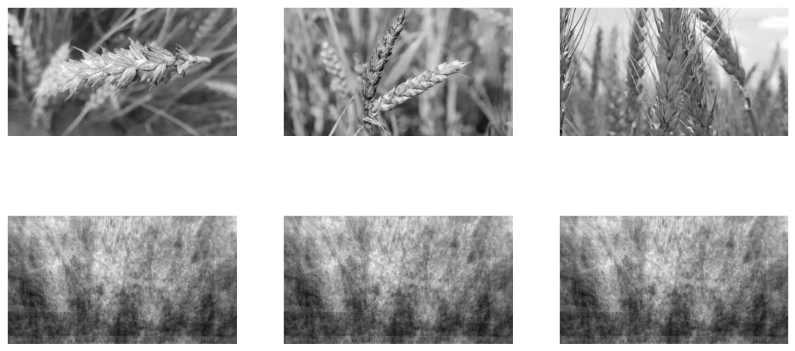

In [19]:
test(model, xTrain_imag)